In [102]:
from pathlib import Path
from typing import Dict, Tuple, List, Iterable, Mapping, Optional, Sequence
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations

# --- Configure the runs you want to inspect ---------------------------------
RUNS_DIR = Path("/data/scastedo/runs_test_fast2")
AMPAR_VALUES: List[float] = [1.0,0.63]
RIN_VALUES: List[float] = [1.0, 1.22]
ETA_VALUES: List[float] = [0, 0.02, 0.04]
TEMP_VALUES: List[float] = [0.01,0.02]
IDIR_VALUES: List[float] = [0.5, 0.503, 0.505, 0.5075, 0.51, 0.515, 0.52, 0.53]
TRIAL_INDICES: List[int] = list(range(1))  # trial00 … trial19
# ----------------------------------------------------------------------------

def run_id(ampar: float, rin: float,sigma_temp:float, sigma_eta: float, idir: float, trial: int) -> str:
    """Build folder name for a simulation run."""
    suffix =""# "_gain_scan_1_1" if ampar == 1.0 else "_gain_scan_063_122"
    return f"g{ampar:.3f}_rin{rin:.3f}_sigmatemp{sigma_temp:.3f}_sigmaeta{sigma_eta:.3f}_idir{idir:.6f}_trial{trial:02d}{suffix}"


def load_state_matrix(folder: Path) -> np.ndarray:
    """Load a single run’s state history as neurons × generations."""
    history_file = folder / "state_history.npy"
    if not history_file.exists():
        raise FileNotFoundError(f"Missing state history file: {history_file}")
    states = np.load(history_file)  # generations × neurons
    if states.ndim != 2:
        raise ValueError(f"Expected 2‑D array in {history_file}, got {states.shape}")
    return states.T  # neurons × generations


def build_state_tensors(
    runs_dir: Path = RUNS_DIR,
    ampar_values: Iterable[float] = AMPAR_VALUES,
    rin_values: Iterable[float] = RIN_VALUES,
    eta_values: Iterable[float] = ETA_VALUES,
    temp_values: Iterable[float] = TEMP_VALUES,
    idir_values: Iterable[float] = IDIR_VALUES,
    trials: Iterable[int] = TRIAL_INDICES,
) -> Dict[Tuple[float, float, float, float], np.ndarray]:
    """
    Return tensors keyed by (ampar, rin, sigma_temp, sigma_eta):
      shape = (neurons, generations, trials, idir)
    """
    tensors: Dict[Tuple[float, float, float, float], np.ndarray] = {}
    for ampar in ampar_values:
        for rin in rin_values:
            if (ampar==1.0 and rin==1.22) or (ampar==0.63 and rin==1.0):
                continue
            for sigma_temp in temp_values:
                for sigma_eta in eta_values:
                    idir_blocks = []
                    for idir in idir_values:
                        trial_blocks = []
                        for trial in trials:
                            folder = runs_dir / run_id(ampar, rin, sigma_temp, sigma_eta, idir, trial)
                            trial_blocks.append(load_state_matrix(folder))
                        trial_cube = np.stack(trial_blocks, axis=2)  # neurons × generations × trials
                        idir_blocks.append(trial_cube)
                    tensors[(ampar, rin, sigma_temp, sigma_eta)] = np.stack(idir_blocks, axis=3)  # neurons × generations × trials × idir
    return tensors

In [103]:
def smooth_state(state: np.ndarray, window_size: int = 5) -> np.ndarray:
    """
    Rolling mean over generations axis (axis=1); keeps other dims.
    Expects shape (neurons, generations, trials, idir).
    """
    if window_size < 1:
        raise ValueError("window_size must be >= 1")
    cumsum = np.cumsum(state, axis=1)
    cumsum[:, window_size:] = cumsum[:, window_size:] - cumsum[:, :-window_size]
    return cumsum[:, window_size - 1:] / window_size

def compute_snr_per_mode(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    neurons, _, trials, idirs = state.shape

    snr_per_mode = np.zeros((trials, neurons))
    evals_per_mode = np.zeros((trials, neurons))
    angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
    other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
    for trial in range(trials):
        delta_mu = state[:, :, trial, angle].mean(axis=1) - state[:, :, trial, other_angle].mean(axis=1)
        covariance = np.cov(state[:, :, trial, angle])
        evals, evecs = np.linalg.eigh(covariance)
        for k in range(evals.shape[0]):
            pc = evecs[:, k]
            signal_proj = np.dot(delta_mu, pc)  # optional: / np.linalg.norm(delta_mu)
            snr_per_mode[trial, k] = signal_proj ** 2  # optional: / evals[k]
            evals_per_mode[trial, k] = evals[k]

    return snr_per_mode, evals_per_mode


def compute_snr_per_mode2(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    neurons, _, trials, idirs = state.shape
    #collapse trial onto generation axis
    state = state.reshape((neurons, -1, idirs))
    snr_per_mode = np.zeros(( neurons))
    evals_per_mode = np.zeros((neurons))
    angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
    other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
    delta_mu = state[:, :, angle].mean(axis=1) - state[:, :, other_angle].mean(axis=1)
    covariance = np.cov(state[:, :, angle])
    evals, evecs = np.linalg.eigh(covariance)

    snr_1= delta_mu.T @ np.linalg.pinv(covariance) @ delta_mu
    for k in range(evals.shape[0]):
        pc = evecs[:, k]
        signal_proj = np.dot(delta_mu, pc)  # optional: / np.linalg.norm(delta_mu)
        snr_per_mode[k] = signal_proj ** 2  # optional: / evals[k]
        evals_per_mode[k] = evals[k]

    return snr_per_mode, evals_per_mode, snr_1, delta_mu

def compute_snr_per_delta(state: np.ndarray, idir_values: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    state: (neurons, generations, trials, idir)
    idir_values: array-like of length idir
    Returns:
        deltas: (num_pairs * trials,) absolute ΔIdir for each trial/pair
        snr:    (num_pairs * trials,) δ^T C^{-1} δ for each trial/pair
    """
    neurons, _, trials, idirs = state.shape
    if len(idir_values) != idirs:
        raise ValueError("len(idir_values) must match state.shape[3]")

    # mean over generations → shape (neurons, trials, idir)
    means = state.mean(axis=1)


    deltas, snrs = [], []

    # use combinations to avoid duplicate (i, j) vs (j, i); include both if you prefer symmetry
    for idir_i, idir_j in combinations(range(idirs), 2):
        delta_idir = abs(idir_values[idir_i] - idir_values[idir_j])
        delta_mu = means[:, :, idir_i] - means[:, :, idir_j]  # (neurons, trials)

        for trial in range(trials):
            try:
                evals, evecs = np.linalg.eigh(np.cov(state[:, :, trial, idir_i], ddof=1))
                proj = evecs.T @ delta_mu[:, trial]      # (neurons,)
                snr_trial = np.sum((proj ** 2) / (evals+1e-12))
                deltas.append(delta_idir)
                snrs.append(snr_trial)
            except np.linalg.LinAlgError:
                continue

            # if you also want the symmetric direction, add this block:
            # evals_b, evecs_b = eig_cache[trial][idir_j]
            # proj_b = evecs_b.T @ (-delta_mu[:, trial])  # negative delta
            # snr_b = np.sum((proj_b ** 2) / (evals_b))
            # deltas.append(delta_idir)
            # snrs.append(snr_b)

    return np.asarray(deltas), np.asarray(snrs)


def overlap_function(tensors, ampar, rin, sigma_eta, sigma_temp, idir1, idir2,k=2, window_size=100):
    state1 = tensors[ampar, rin, sigma_temp,sigma_eta]
    # smoothed_state1 = smooth_state(state1, window_size = 100) #################################################3 WINDOW SIZE TO BE MODIFIED

    # average over every 10 generations and then save this
    average_size = window_size
    n_neurons, n_generations, n_trials, n_idir = state1.shape
    n_blocks = n_generations // average_size  # integer division
    cut = n_blocks * average_size             # how many generations to keep

    data_trimmed = state1[:, :cut, :, :]
    data_reshaped = data_trimmed.reshape(n_neurons, n_blocks, average_size, n_trials, n_idir)
    data_avg = data_reshaped.mean(axis=2)

    

    overlap, evals, snr_1, delmu = compute_snr_per_mode2(data_avg,idir_1=idir1,idir_2 = idir2)
    for _ in range(k):
        max_idx = np.argmax(evals)#, axis=1)
        evals = np.delete(evals, max_idx)#, axis=1)
        overlap = np.delete(overlap, max_idx)#, axis=1)

    # Compute means across animals
    # mean_evals = evals.mean(axis=0)
    # mean_overlap = overlap.mean(axis=0)
    # mean_evals = evals.flatten()
    # mean_overlap = overlap.flatten()
    # mask = mean_evals > 1e-10
    # mean_evals = mean_evals[mask]
    # mean_overlap = mean_overlap[mask]

    mean_evals = evals[:]
    mean_overlap = overlap[:]
    # Linear fit
    a, b = np.polyfit(mean_evals, mean_overlap, deg=1)

    # Generate smooth line
    xfit = np.linspace(mean_evals.min(), mean_evals.max(), 200)
    yfit = a * xfit + b

    return mean_evals, mean_overlap, xfit, yfit, a, b, snr_1, delmu


def snr_delta_function(tensors, ampar, rin, sigma_eta, sigma_temp):
    state1 = tensors[ampar, rin, sigma_temp,sigma_eta]
    smoothed_state1 = smooth_state(state1, window_size = 5)
    deltas, snrs = compute_snr_per_delta(smoothed_state1, np.array(IDIR_VALUES))

    unique_deltas = np.unique(deltas)
    avg_snrs = []
    error_snrs = []
    for delta in unique_deltas:
        snr_values = snrs[deltas == delta]
        avg_snrs.append(np.mean(snr_values))
        error_snrs.append(np.std(snr_values) / np.sqrt(len(snr_values)))

    return unique_deltas, np.array(avg_snrs), np.array(error_snrs)

In [104]:
tensors = build_state_tensors()

KeyError: (1.0, 1.0, 0.0, 0.1)

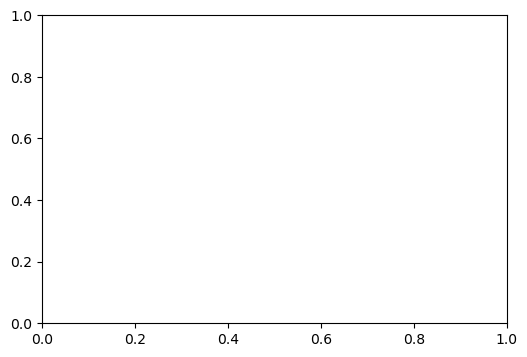

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))
size = 100
k_val = 4
angle_2 = 0.501
mean_evals, mean_overlap, xfit, yfit, a, b, snrog1= overlap_function(
    tensors, ampar=1.0, rin=1.0, sigma_temp=0.0,sigma_eta=0.1,  idir1=0.5, idir2=angle_2, k=k_val, window_size=size
)
ax.plot(mean_evals, mean_overlap, 'o', markersize=0.5)
ax.plot(xfit, yfit, "-", color="blue", lw=2)
snr_1 = np.sum(mean_overlap/mean_evals)

mean_evals, mean_overlap, xfit, yfit, a, b, snrog2 = overlap_function(
    tensors, ampar=1, rin=1, sigma_temp=0.1,sigma_eta=0.1,  idir1=0.5, idir2=angle_2,k=k_val, window_size=size
)
ax.plot(mean_evals, mean_overlap, 'o', markersize=0.5)
ax.plot(xfit, yfit, "-", color="red", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()
plt.show()
snr_2 = np.sum(mean_overlap/mean_evals)
print(snr_1/snr_2)


5.553478959851611


[]

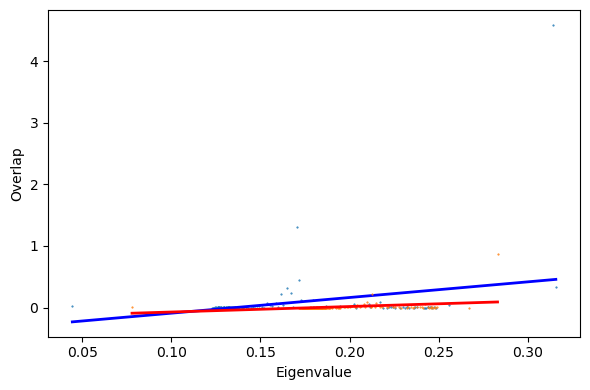

In [156]:
fig, ax = plt.subplots(figsize=(6, 4))

angle_2 = 0.8
mean_evals, mean_overlap, xfit, yfit, a, b = overlap_function(
    tensors, ampar=1.0, rin=1.0, sigma_temp=0.0,sigma_eta=0.1,  idir1=0.5, idir2=angle_2, k=k_val, window_size=size
)
ax.plot(mean_evals, mean_overlap, 'o', markersize=0.5)
ax.plot(xfit, yfit, "-", color="blue", lw=2)
snr_1 = np.sum(mean_overlap/mean_evals)

mean_evals, mean_overlap, xfit, yfit, a, b = overlap_function(
    tensors, ampar=1, rin=1, sigma_temp=0.1,sigma_eta=0.1,  idir1=0.5, idir2=angle_2,k=k_val, window_size=size
)
ax.plot(mean_evals, mean_overlap, 'o', markersize=0.5)
ax.plot(xfit, yfit, "-", color="red", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()
snr_2 = np.sum(mean_overlap/mean_evals)
print(snr_1/snr_2)
plt.plot()

KeyError: (1, 1, 0.05, 0.1)

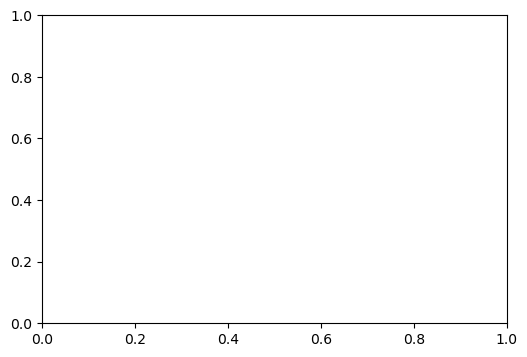

In [ ]:
#TEST DIFFERENT TEMPS
fig, ax = plt.subplots(figsize=(6, 4))
size = 50
k_val = 5
angle_2 = 0.51

sig_temp1 = 0.05
sig_temp2 = 0.0
sig_eta = 0.1

mean_evals1, mean_overlap1, xfit, yfit, a, b,snr_1og, deltamu1 = overlap_function(
    tensors, ampar=1, rin=1, sigma_temp=sig_temp1,sigma_eta=sig_eta,  idir1=0.5, idir2=angle_2, k=k_val, window_size=size
)
ax.plot(mean_evals1, mean_overlap1, 'o', markersize=2, color="red")
# ax.plot(xfit, yfit, "-", color="blue", lw=2)
snr_1 = np.sum(mean_overlap1/mean_evals1)

mean_evals2, mean_overlap2, xfit, yfit, a, b, snr_2og,deltamu2 = overlap_function(
    tensors, ampar=1, rin=1, sigma_temp=sig_temp2,sigma_eta=sig_eta,  idir1=0.5, idir2=angle_2,k=k_val, window_size=size
)
ax.plot(mean_evals2, mean_overlap2, 'o', markersize=2, color="blue")
# ax.plot(xfit, yfit, "-", color="red", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()
snr_2 = np.sum(mean_overlap2/mean_evals2)
# print(snr_1/snr_2)
print(snr_1og/snr_2og)
print("Dmu norm ampar=0.63:", np.linalg.norm(deltamu1))
print("Dmu norm ampar=1.0:", np.linalg.norm(deltamu2))
plt.show()
plt.hist(mean_evals1, bins=50, color="red", alpha=0.5, label="ampar=0.63", density=True)
plt.hist(mean_evals2, bins=50, color="blue", alpha=0.5, label="ampar=1.0", density=True)
plt.xlabel("Eigenvalue")
plt.ylabel("Count")
participation_ratio1 = (np.sum(mean_evals1))**2/np.sum(mean_evals1**2)
participation_ratio2 = (np.sum(mean_evals2))**2/np.sum(mean_evals2**2)
print("Participation ratio ampar=0.63:", participation_ratio1)
print("Participation ratio ampar=1.0:", participation_ratio2)   
print('participation ratio FR/CTR:', participation_ratio1/participation_ratio2)
print('Mean_Eigval_Ratio FR/CTR:', np.mean(mean_evals1)/np.mean(mean_evals2))

0.5168654812522154
Dmu norm ampar=0.63: 0.44695377
Dmu norm ampar=1.0: 0.60832036


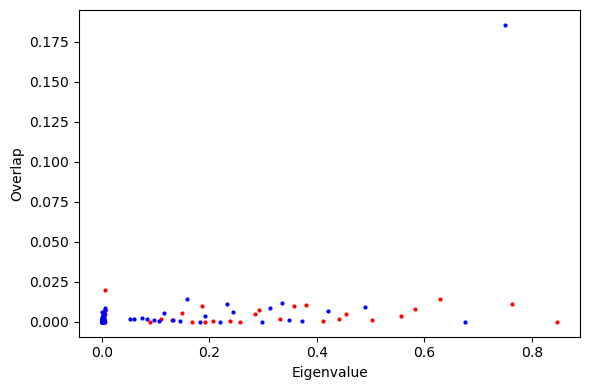

Participation ratio ampar=0.63: 18.703653038857155
Participation ratio ampar=1.0: 16.397955986569976
participation ratio FR/CTR: 1.140608808450002
Mean_Eigval_Ratio FR/CTR: 1.4029854022810342


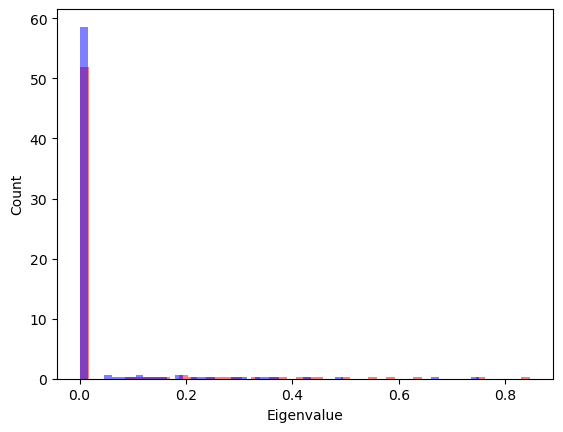

In [52]:
# TEST FR VS CTR

fig, ax = plt.subplots(figsize=(6, 4))
size = 50
k_val = 0
angle_2 = 0.51
sig_temp = 0.01
sig_eta = 0.05
mean_evals1, mean_overlap1, xfit, yfit, a, b,snr_1og, dmu1 = overlap_function(
    tensors, ampar=0.63, rin=1.22, sigma_temp=sig_temp,sigma_eta=sig_eta,  idir1=0.5, idir2=angle_2, k=k_val, window_size=size
)
ax.plot(mean_evals1, mean_overlap1, 'o', markersize=2, color="red")
# ax.plot(xfit, yfit, "-", color="blue", lw=2)
snr_1 = np.sum(mean_overlap1/mean_evals1)

mean_evals2, mean_overlap2, xfit, yfit, a, b, snr_2og, dmu2 = overlap_function(
    tensors, ampar=1, rin=1, sigma_temp=sig_temp,sigma_eta=sig_eta,  idir1=0.5, idir2=angle_2,k=k_val, window_size=size
)
ax.plot(mean_evals2, mean_overlap2, 'o', markersize=2, color="blue")
# ax.plot(xfit, yfit, "-", color="red", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()
snr_2 = np.sum(mean_overlap2/mean_evals2)
# print(snr_1/snr_2)
print(snr_1og/snr_2og)
print("Dmu norm ampar=0.63:", np.linalg.norm(dmu1))
print("Dmu norm ampar=1.0:", np.linalg.norm(dmu2))
plt.show()
plt.hist(mean_evals1, bins=50, color="red", alpha=0.5, label="ampar=0.63", density=True)
plt.hist(mean_evals2, bins=50, color="blue", alpha=0.5, label="ampar=1.0", density=True)
plt.xlabel("Eigenvalue")
plt.ylabel("Count")
participation_ratio1 = (np.sum(mean_evals1))**2/np.sum(mean_evals1**2)
participation_ratio2 = (np.sum(mean_evals2))**2/np.sum(mean_evals2**2)
print("Participation ratio ampar=0.63:", participation_ratio1)
print("Participation ratio ampar=1.0:", participation_ratio2)   
print('participation ratio FR/CTR:', participation_ratio1/participation_ratio2)
print('Mean_Eigval_Ratio FR/CTR:', np.mean(mean_evals1)/np.mean(mean_evals2))

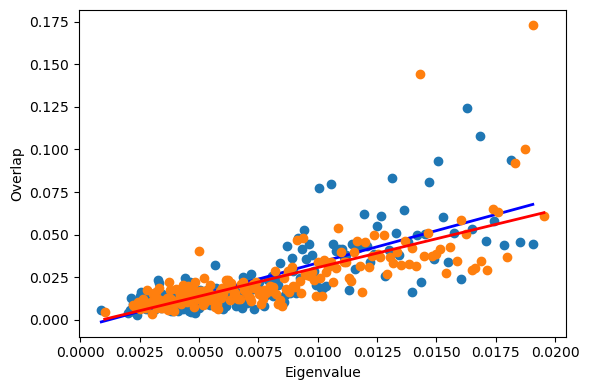

In [5]:
# AMPAR_VALUES: List[float] = [1.0,0.63]
# RIN_VALUES: List[float] = [1.0, 1.22]
# ETA_VALUES: List[float] = [0.0, 0.1]
# TEMP_VALUES: List[float] = [0.0, 0.01]

# Plot Overlap vs Eigenvalues
## For each ampar, rin, sigma_eta, sigma_temp AND IDIR combination
fig, ax = plt.subplots(figsize=(6, 4))

mean_evals, mean_overlap, xfit, yfit, a, b = overlap_function(
    tensors, ampar=1.0, rin=1.0, sigma_temp=0.0,sigma_eta=0.1,  idir1=0.5, idir2=0.8
)
ax.plot(mean_evals, mean_overlap, "o")
ax.plot(xfit, yfit, "-", color="blue", lw=2)

mean_evals, mean_overlap, xfit, yfit, a, b = overlap_function(
    tensors, ampar=0.63, rin=1.22, sigma_temp=0.0,sigma_eta=0.1,  idir1=0.5, idir2=0.8
)
ax.plot(mean_evals, mean_overlap, "o")
ax.plot(xfit, yfit, "-", color="red", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()

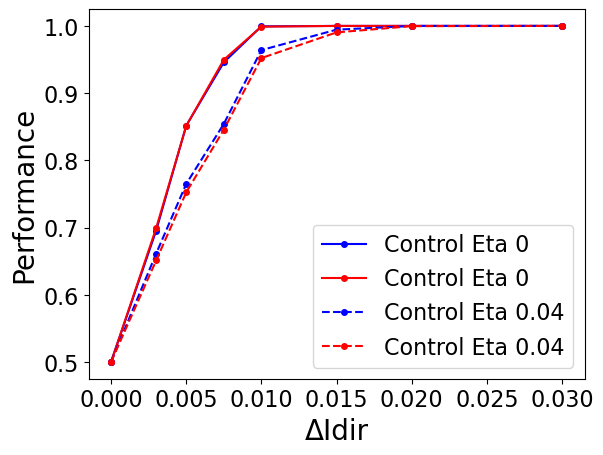

In [120]:
from scipy.stats import norm
def compute_snrs(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    neurons, _, trials, idirs = state.shape
    state = state.reshape((neurons, -1, idirs))
    angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
    other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
    delta_mu = state[:, :, angle].mean(axis=1) - state[:, :, other_angle].mean(axis=1)
    covariance = np.cov(state[:, :, angle])

    snr_1= delta_mu.T @ np.linalg.pinv(covariance) @ delta_mu


    return snr_1

def compute_snr_per_delta(state: np.ndarray, idir_values: np.ndarray, window_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    state: (neurons, generations, trials, idir)
    idir_values: array-like of length idir
    Returns:
        deltas: (num_pairs * trials,) absolute ΔIdir for each trial/pair
        snr:    (num_pairs * trials,) δ^T C^{-1} δ for each trial/pair
    """
    neurons, _, trials, idirs = state.shape
    if len(idir_values) != idirs:
        raise ValueError("len(idir_values) must match state.shape[3]")
    average_size = window_size
    n_neurons, n_generations, n_trials, n_idir = state.shape
    n_blocks = n_generations // average_size  # integer division
    cut = n_blocks * average_size             # how many generations to keep

    data_trimmed = state[:, :cut, :, :]
    data_reshaped = data_trimmed.reshape(n_neurons, n_blocks, average_size, n_trials, n_idir)
    data_avg = data_reshaped.mean(axis=2)

    deltas, snrs = [], []

    # use combinations to avoid duplicate (i, j) vs (j, i); include both if you prefer symmetry
    # for idir_i, idir_j in combinations(range(idirs), 2):
    #     delta_idir = abs(idir_values[idir_i] - idir_values[idir_j])
    #     deltas.append(delta_idir)
    #     snrs.append(compute_snrs(data_avg, idir_1=idir_values[idir_i], idir_2=idir_values[idir_j]))

    idir_i = 0.5
    for idir_j in range(idirs):
      
        delta_idir = abs(idir_values[idir_j] - idir_i)
        deltas.append(delta_idir)
        snrs.append(compute_snrs(data_avg, idir_1=idir_i, idir_2=idir_values[idir_j]))

    return np.asarray(deltas), np.asarray(snrs)
def snr_to_performance(snrval):
    dprime = np.sqrt(snrval)
    z = dprime / np.sqrt(2)
    perf = norm.cdf(z)
    return perf
    # return snrval

def plot_snr_delta(ampar, rin, sigma_eta, sigma_temp):
    delta_vals, snr_vals = compute_snr_per_delta(tensors[ampar,rin,sigma_temp,sigma_eta], IDIR_VALUES, window_size=window)
    sorted_delta_vals1 = np.sort(delta_vals)
    sorted_snr_vals1 = snr_vals[np.argsort(delta_vals)]
    return sorted_delta_vals1,snr_to_performance(sorted_snr_vals1)



window = 1
temp = 0.01

eta = 0.00
plt.plot(plot_snr_delta(1,1,eta,temp)[0], plot_snr_delta(1,1,eta,temp)[1], 'o-',color = 'blue', label = 'Control Eta 0',markersize = 4)

plt.plot(plot_snr_delta(0.63,1.22,eta,temp)[0], plot_snr_delta(0.63,1.22,eta,temp)[1],'o-', label = 'Control Eta 0',color = 'red', markersize = 4)


eta = 0.04
plt.plot(plot_snr_delta(1,1,eta,temp)[0], plot_snr_delta(1,1,eta,temp)[1], 'o--',color = 'blue', label = 'Control Eta 0.04',markersize = 4)
plt.plot(plot_snr_delta(0.63,1.22,eta,temp)[0], plot_snr_delta(0.63,1.22,eta,temp)[1],'o--', label = 'Control Eta 0.04',color = 'red', markersize = 4)


plt.xlabel("ΔIdir", fontsize=20)
plt.ylabel("Performance", fontsize=20)
# plt.title("Performance vs ΔIdir at Temp = 0.01, Eta = 0.01", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

# plt.xlim(0,0.023)
# plt.ylim(0.5,.9)


Text(0, 0.5, 'Delta X vector')

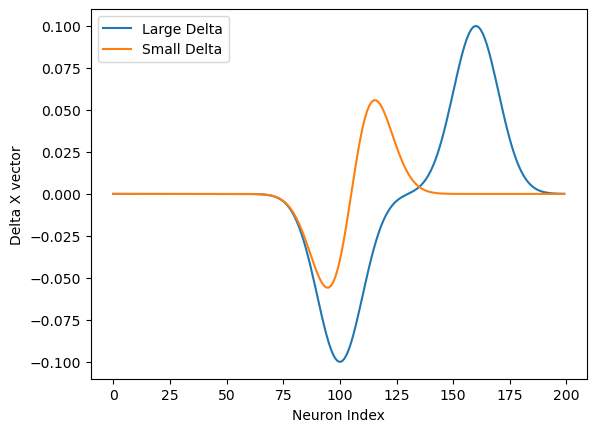

In [111]:
Idir = 0.5
N = 200
Sig_input = 0.05
AMP = 0.1
delta = .005


def get_bump(idir, num_neurons, sigma_input, amplitude):
    center_index_tensor = np.full(num_neurons, int(idir*num_neurons))

    sigma_idx = sigma_input * num_neurons                        # width in *index* units
    d0 = np.arange(0, (num_neurons//2)+1)
    bump_LUT = np.exp(-0.5 * (d0 / sigma_idx)**2)  # size ≈ N/2+1
    distances = np.arange(num_neurons)
    distances = np.abs(distances - center_index_tensor)
    distances = np.minimum(distances, num_neurons - distances)
    distance_to_center = distances
    input_bump_profile = amplitude* bump_LUT[distances]
    return input_bump_profile

bump = get_bump(Idir, N, Sig_input, AMP)
bump_dx  = get_bump(Idir + delta, N, Sig_input, AMP)

delta_x = bump_dx - bump


plt.plot(np.arange(N), get_bump(Idir + 0.3, N, Sig_input, AMP) - bump, label = 'Large Delta')
plt.plot(np.arange(N), get_bump(Idir + 0.05, N, Sig_input, AMP) - bump, label = 'Small Delta')
plt.legend()
plt.xlabel('Neuron Index')
plt.ylabel('Delta X vector')